# Determinental Point Process (DPP)

This notebook demonstrates how to draw random samples from FiniteDPP process defined by a square exponential similarity kernel with different values of lenght_scale and prefactor. 

For each combination of lenght_scale and prefactor, we draw a random sample and compute the average and the standard deviation in the number of objects.

In [4]:
#!pip install -U neptune-notebooks

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy
from genus.util_ml import Grid_DPP, compute_logp_bernoulli
from genus.util_vis import show_batch

In [12]:
class simplified_model(torch.nn.Module):
    def __init__(self,
                 length_scale: float,
                 weight: float):
        super().__init__()
        B, W, H = 8, 10, 10
        self.n_mc_samples = 100
        self.grid_dpp = Grid_DPP(length_scale=length_scale,
                                 weight=weight,
                                 learnable_params=False)
        
        self.logit = torch.nn.Parameter(data=torch.randn((B,1,W,H), dtype=torch.float), requires_grad=True)
    
    def forward(self, generate_synthetic_data=False):
        prob = torch.sigmoid(self.logit)

        if generate_synthetic_data:
            # sample from dpp prior
            c_grid_before_nms_mcsamples = self.grid_dpp.sample(size=prob.size()).unsqueeze(dim=0)
        else:
            prob_expanded = prob.expand([n_mc_samples] + list(prob.shape))
            c_grid_before_nms_mcsamples = (torch.rand_like(prob_expanded) < prob_expanded)
        
        logp_ber_before_nms_mb = compute_logp_bernoulli(c=c_grid_before_nms_mcsamples.detach(),
                                                        logit=self.logit).sum(dim=(-1, -2, -3))
        logp_dpp_before_nms_mb = self.grid_dpp.log_prob(value=c_grid_before_nms_mcsamples.squeeze(-3).detach())
        f = logp_ber_before_nms_mb - logp_dpp_before_nms_mb
        baseline = f.mean(dim=-2).detach()
        logit_kl_av = torch.mean(logp_ber_before_nms_mb * (f-baseline).detach() + (f-baseline))
        loss = logit_kl_av
        return loss, c_grid_before_nms_mcsamples




In [ ]:
import neptune.new as neptune

exp = neptune.init(project='dalessioluca/genus-new')
                                    
model = simplified_model(length_scale=5.0, weight=0.2)
optimizer = torch.optim.Adam([{'params': model.parameters(), 'lr': 0.001}])

In [39]:
loss, c_grid = model.forward(generate_synthetic_data=True)

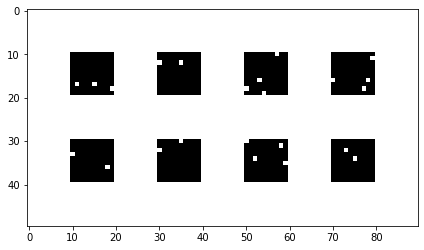

In [41]:
show_batch(c_grid[0].float())

In [37]:
for epoch in range(1000):
    loss, c_grid = model.forward()
    
    optimizer.zero_grad()
    loss.backward()  # do back_prop and compute all the gradients
    optimizer.step()  # update the parameters    
    
    if epoch % 100 == 0:
        n_cell = c_grid.sum(dim=(-1,-2,-3)).float().mean().detach().item()
        exp["n_cell"].log(n_cell)
        logit_min = torch.min(model.logit).item()
        logit_mean = torch.mean(model.logit).item()
        logit_max = torch.max(model.logit).item()
        exp["logit/min"].log(logit_min)
        exp["logit/mean"].log(logit_mean)
        exp["logit/max"].log(logit_max)
        
        show_batch(c_grid[0].float(), pad_value=0.5, n_padding=2, experiment=exp, neptune_name="c_grid", 
                   title="epoch="+str(epoch))
        show_batch(model.logit, pad_value=1.0, n_padding=2, normalize_range=(-3.0, 3.0), 
               normalize=True, experiment=exp, neptune_name="logit", title="epoch="+str(epoch))
        
        
    
        print(epoch, loss)
    
    

0 tensor(-4.0408, grad_fn=<MeanBackward0>)
100 tensor(-1.9962, grad_fn=<MeanBackward0>)
200 tensor(-2.8233, grad_fn=<MeanBackward0>)
300 tensor(-2.1188, grad_fn=<MeanBackward0>)
400 tensor(-2.0692, grad_fn=<MeanBackward0>)
500 tensor(-1.2881, grad_fn=<MeanBackward0>)
600 tensor(-2.1219, grad_fn=<MeanBackward0>)
700 tensor(-2.4222, grad_fn=<MeanBackward0>)
800 tensor(0.0190, grad_fn=<MeanBackward0>)
900 tensor(-2.1665, grad_fn=<MeanBackward0>)


In [ ]:
model.

In [ ]:
exp.stop()

In [21]:
c_grid[0].shape

torch.Size([8, 1, 10, 10])

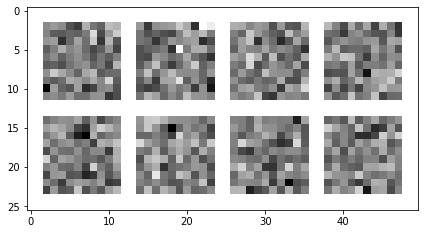

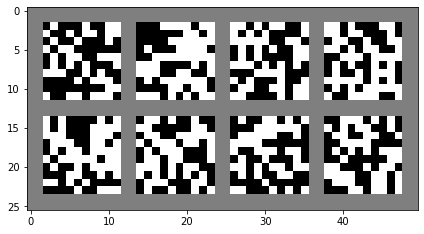

In [27]:
show_batch(c_grid[0].float(), pad_value=0.5, n_padding=2, experiment=exp, neptune_name="c_grid")